### ADVERSIAL TRAINING

### Modèle de base  

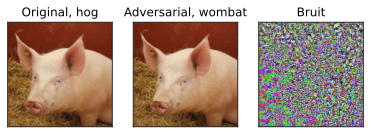

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]



import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

# form predictions
pred = model(norm(pig_tensor))

import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
"""print(imagenet_classes[pred.max(dim=1)[1].item()])"""
hog = imagenet_classes[pred.max(dim=1)[1].item()]

# 341 is the class index corresponding to "hog"
"""print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())"""

import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    """if t % 5 == 0:
        print(t, loss.item())"""
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
"""print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())"""

max_class = pred.max(dim=1)[1].item()
"""print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())"""


# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)


fig, ax = plt.subplots(1, 3)
ax[0].imshow(pig_tensor[0].numpy().transpose(1,2,0))
ax[0].set_title(f"Original, {hog}")
ax[0].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))
ax[1].set_title(f"Adversarial, {imagenet_classes[max_class]}")
ax[1].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

ax[2].imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
ax[2].set_title("Bruit")
ax[2].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.show()

### Nouveau modèle entrainé

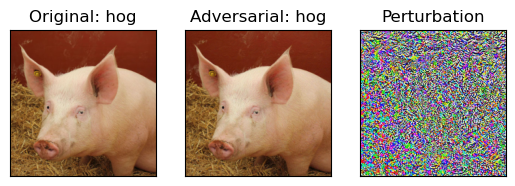

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Charger l'image
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None, :, :, :]

# Normalisation pour ImageNet
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
hog = imagenet_classes[pred.max(dim=1)[1].item()]

# Charger le modèle pré-entraîné
model = resnet50(pretrained=True).train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Données de l'image
pig_tensor = pig_tensor.to(device)
target_class = 341  # Classe "hog" dans ImageNet

epsilon = 2. / 255
learning_rate = 1e-3
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement avec adversarial training
for epoch in range(num_epochs):
    delta = torch.zeros_like(pig_tensor, requires_grad=True).to(device)
    
    for _ in range(30):  
        pred = model(norm(pig_tensor + delta))
        loss_adv = -criterion(pred, torch.LongTensor([target_class]).to(device))
        loss_adv.backward()
        delta.data = (delta + epsilon * delta.grad.sign()).clamp_(-epsilon, epsilon)  
        delta.grad.zero_()

    adversarial_image = (pig_tensor + delta).clamp(0, 1)
    pred_original = model(norm(pig_tensor))
    pred_adversarial = model(norm(adversarial_image))
    
    loss_original = criterion(pred_original, torch.LongTensor([target_class]).to(device))
    loss_combined = (loss_original + criterion(pred_adversarial, torch.LongTensor([target_class]).to(device))) / 2

    optimizer.zero_grad()
    loss_combined.backward()
    optimizer.step()

# Visualisation après entraînement
model.eval()
with torch.no_grad():
    pred = model(norm(pig_tensor))
    pred_adv = model(norm(pig_tensor + delta))
    original_class = pred.max(dim=1)[1].item()
    adversarial_class = pred_adv.max(dim=1)[1].item()

# Visualisation des résultats
fig, ax = plt.subplots(1, 3)
ax[0].imshow(pig_tensor[0].cpu().numpy().transpose(1, 2, 0))  # Image originale
ax[0].set_title(f"Original: {imagenet_classes[original_class]}")
ax[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

ax[1].imshow((pig_tensor + delta).detach()[0].cpu().numpy().transpose(1, 2, 0))  # Image adversariale
ax[1].set_title(f"Adversarial: {imagenet_classes[adversarial_class]}")
ax[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

ax[2].imshow((50 * delta.detach() + 0.5)[0].cpu().numpy().transpose(1, 2, 0))  # Perturbation
ax[2].set_title("Perturbation")
ax[2].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

plt.show()



On regarde si cela marche aussi pour ce qui était prédi comme un avion de ligne.

0 23.633281707763672
10 5.968674182891846
20 3.7480061054229736
30 3.393592357635498
40 3.182795286178589
50 3.019865036010742
60 2.8909623622894287
70 2.7813732624053955
80 2.6854100227355957
90 2.6000702381134033
Predicted class:  hog
Predicted probability: 0.04788682237267494


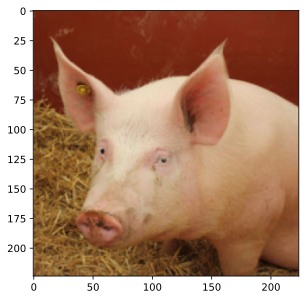

In [13]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

max_class = pred.max(dim=1)[1].item()

print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

On a bien une prédiction de cochon.

### Code complet

Epoch [1/10], Loss: 5.8156
Epoch [2/10], Loss: 2.2516
Epoch [3/10], Loss: 0.0878
Epoch [4/10], Loss: 0.0063
Epoch [5/10], Loss: 0.0011
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


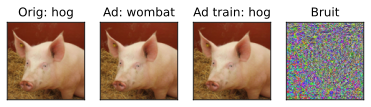

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Charger l'image
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None, :, :, :]

# Normalisation pour ImageNet
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model50 = resnet50(pretrained=True)
model50.eval();

# form predictions
pred50 = model50(norm(pig_tensor))

import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
hog = imagenet_classes[pred50.max(dim=1)[1].item()]

import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred50 = model50(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred50, torch.LongTensor([341]))
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

max_class = pred50.max(dim=1)[1].item()

# Charger le modèle pré-entraîné
model = resnet50(pretrained=True).train()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Données de l'image
pig_tensor = pig_tensor.to(device)
target_class = 341  # Classe "hog" dans ImageNet

epsilon = 2. / 255
learning_rate = 1e-3
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement avec adversarial training
for epoch in range(num_epochs):
    delta = torch.zeros_like(pig_tensor, requires_grad=True).to(device)
    
    for _ in range(30): 
        pred = model(norm(pig_tensor + delta))
        loss_adv = -criterion(pred, torch.LongTensor([target_class]).to(device))
        loss_adv.backward()
        delta.data = (delta + epsilon * delta.grad.sign()).clamp_(-epsilon, epsilon)
        delta.grad.zero_()

    adversarial_image = (pig_tensor + delta).clamp(0, 1)
    pred_original = model(norm(pig_tensor))
    pred_adversarial = model(norm(adversarial_image))
    
    loss_original = criterion(pred_original, torch.LongTensor([target_class]).to(device))
    loss_combined = (loss_original + criterion(pred_adversarial, torch.LongTensor([target_class]).to(device))) / 2

    optimizer.zero_grad()
    loss_combined.backward()
    optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}]")

# Visualisation après entraînement
model.eval()
with torch.no_grad():
    pred = model(norm(pig_tensor))
    pred_adv = model(norm(pig_tensor + delta))
    original_class = pred.max(dim=1)[1].item()
    adversarial_class = pred_adv.max(dim=1)[1].item()

# Visualisation des résultats
fig, ax = plt.subplots(1, 4)
ax[0].imshow(pig_tensor[0].cpu().numpy().transpose(1, 2, 0))  # Image originale
ax[0].set_title(f"Orig: {imagenet_classes[original_class]}")
ax[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

ax[1].imshow((pig_tensor + delta).detach()[0].cpu().numpy().transpose(1, 2, 0))  # Image adversariale
ax[1].set_title(f"Ad: {imagenet_classes[max_class]}")
ax[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

ax[2].imshow((pig_tensor + delta).detach()[0].cpu().numpy().transpose(1, 2, 0))  # Image adversariale
ax[2].set_title(f"Ad train: {imagenet_classes[adversarial_class]}")
ax[2].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

ax[3].imshow((50 * delta.detach() + 0.5)[0].cpu().numpy().transpose(1, 2, 0))  # Perturbation
ax[3].set_title("Bruit")
ax[3].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

plt.show()

